<a href="https://colab.research.google.com/github/binodsth2/Vechicle-Count-Prediction/blob/main/Vehicles_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df=pd.read_csv('/content/drive/MyDrive/Machine_Learning/vehicles.csv')
df.head()

,DateTime,Vehicles
0,2015-11-01 00:00:00,15
1,2015-11-01 01:00:00,13
2,2015-11-01 02:00:00,10
3,2015-11-01 03:00:00,7
4,2015-11-01 04:00:00,9


In [15]:
# Check for missing values
print(df.isnull().sum())

DateTime    0
Vehicles    0
dtype: int64


In [16]:
# Fill or drop missing values if any
df = df.dropna()


In [17]:
# Assuming 'Vehicles' is the target variable
target = 'Vehicles'
features = [col for col in df.columns if col != target]

In [18]:
# Scale features
scaler = MinMaxScaler()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [19]:
# Create sequences for LSTM
def create_sequences(data, target_col_index, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps][target_col_index])
    return np.array(X), np.array(y)

# Find the index of the target column
target_col_index = df.columns.get_loc(target)

# Exclude the 'DateTime' column from the data_array
data_array = df[numerical_features + [target]].values
X, y = create_sequences(data_array, target_col_index)

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
X_knn = X.reshape(X.shape[0], -1)
X_train_knn, X_test_knn = X_knn[:len(y_train)], X_knn[len(y_train):]

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_knn, y_train)
y_pred_knn = knn.predict(X_test_knn)
print("KNN R2 Score:", r2_score(y_test, y_pred_knn))
print("KNN RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_knn)))
print("KNN MAE:", mean_absolute_error(y_test, y_pred_knn))

KNN R2 Score: -0.21315823261576816
KNN RMSE: 0.12741325082711366
KNN MAE: 0.09388668194047857


In [24]:
#LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_lstm = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

y_pred_lstm = model_lstm.predict(X_test).flatten()
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lstm)))
print("LSTM MAE:", mean_absolute_error(y_test, y_pred_lstm))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1083/1083 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0014 - val_loss: 7.1339e-04
Epoch 2/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 7.8960e-04 - val_loss: 6.6266e-04
Epoch 3/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 7.3293e-04 - val_loss: 6.6928e-04
Epoch 4/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 7.1562e-04 - val_loss: 6.7457e-04
Epoch 5/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 7.7770e-04 - val_loss: 6.7908e-04
Epoch 6/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7.5570e-04 - val_loss: 7.0754e-04
Epoch 7/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 6.9687e-04 - val_loss: 6.6433e-04
Epoch 8/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.6457e-04 - val_loss: 6.2908e-04
Epoch 9/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 6.6319e-04 - val_loss: 6.2470e-04
Epoch 10/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 6.7437e-04 - val_loss: 6.3803e-04
Epoch 11/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/

In [25]:
#Conv-LSTM Model
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Flatten, Reshape

# Reshape for ConvLSTM: (samples, time, rows, cols, channels)
X_train_conv = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, X_train.shape[2], 1))
X_test_conv = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, X_test.shape[2], 1))

model_convlstm = Sequential([
    ConvLSTM2D(filters=32, kernel_size=(1, 2), input_shape=(X.shape[1], 1, X.shape[2], 1), padding='same', return_sequences=False),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])
model_convlstm.compile(optimizer='adam', loss='mse')
model_convlstm.fit(X_train_conv, y_train, epochs=20, batch_size=32, validation_split=0.1)

y_pred_conv = model_convlstm.predict(X_test_conv).flatten()
print("Conv-LSTM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_conv)))
print("Conv-LSTM MAE:", mean_absolute_error(y_test, y_pred_conv))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1083/1083 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 2/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 9.6965e-04 - val_loss: 0.0014
Epoch 3/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 8.6625e-04 - val_loss: 0.0019
Epoch 4/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 7.9037e-04 - val_loss: 6.7273e-04
Epoch 5/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 7.4640e-04 - val_loss: 7.4247e-04
Epoch 6/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 7.2044e-04 - val_loss: 8.8158e-04
Epoch 7/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 7.6318e-04 - val_loss: 6.9224e-04
Epoch 8/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 7.2482e-04 - val_loss: 7.5154e-04
Epoch 9/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 7.2351e-04 - val_loss: 6.0050e-04
Epoch 10/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 6.6894e-04 - val_loss: 5.7109e-04
Epoch 11/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 10s

In [26]:
# CLSTM (CNN + LSTM Hybrid Model)
from tensorflow.keras.layers import Conv1D, MaxPooling1D

model_clstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dense(1)
])
model_clstm.compile(optimizer='adam', loss='mse')
model_clstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

y_pred_clstm = model_clstm.predict(X_test).flatten()
print("CLSTM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_clstm)))
print("CLSTM MAE:", mean_absolute_error(y_test, y_pred_clstm))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1083/1083 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 2/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 8.4694e-04 - val_loss: 6.9617e-04
Epoch 3/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 8.1215e-04 - val_loss: 6.9313e-04
Epoch 4/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 7.5108e-04 - val_loss: 6.7459e-04
Epoch 5/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 7.6836e-04 - val_loss: 7.0791e-04
Epoch 6/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 7.5964e-04 - val_loss: 6.2681e-04
Epoch 7/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 7.3697e-04 - val_loss: 6.5034e-04
Epoch 8/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 7.0098e-04 - val_loss: 6.9633e-04
Epoch 9/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7.4438e-04 - val_loss: 6.0574e-04
Epoch 10/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.9802e-04 - val_loss: 5.9105e-04
Epoch 11/20
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - 

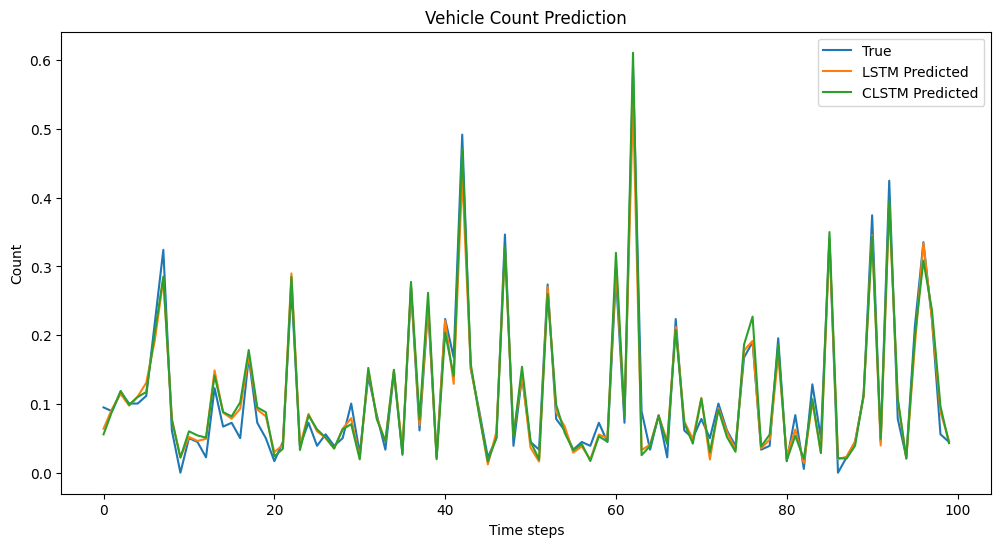

In [27]:
#Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='True')
plt.plot(y_pred_lstm[:100], label='LSTM Predicted')
plt.plot(y_pred_clstm[:100], label='CLSTM Predicted')
plt.legend()
plt.title("Vehicle Count Prediction")
plt.xlabel("Time steps")
plt.ylabel("Count")
plt.show()